# Replica Model — *Enhancing anomaly detection in electrical consumption profiles through computational intelligence* (Energy Reports, 2024)

Notebook này dựng **model y-chang paper** về **pipeline + kiến trúc ANN + output 33 lớp + metric (Accuracy/Precision/FPR/FNR)**.

**Model theo paper:**
1) 15-min data → **Daily Load Profile (DLP)** = 96 điểm/ngày  
2) **Pattern theo weekday** (mean/std từng slot)  
3) **Z-score normalization**  
4) Feature **99** = 96 Z + (max, mean, min) của ngày  
5) **Cataloging 33 classes** (Table 2) → tạo nhãn (pseudo ground-truth)  
6) ANN: **99 → 100(ReLU) → Dropout(0.5) → 33(Sigmoid)**, Adam lr=0.01  
7) Đánh giá: **Accuracy, Precision, FPR, FNR**

> ⚠️ Lưu ý (để “y chang paper” về thí nghiệm): paper có dữ liệu nhiều tòa nhà và nhãn catalog thực tế.  
> Với dataset UCI household, notebook tạo nhãn 33 lớp theo rule (catalog) để bạn chạy end-to-end đúng pipeline.


## Cell 1 — Import + đọc dữ liệu (SỬA `DATA_PATH`)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ✅ SỬA PATH CHO ĐÚNG MÁY BẠN
DATA_PATH = r"D:\AIL303c\data\household_power_consumption.txt"

df = pd.read_csv(DATA_PATH, sep=";", na_values="?", low_memory=False)

df["timestamp"] = pd.to_datetime(df["Date"] + " " + df["Time"], dayfirst=True, errors="coerce")
df = df[["timestamp", "Global_active_power"]].dropna()
df = df.sort_values("timestamp").set_index("timestamp")

print("Rows:", len(df))
df.head()


Rows: 2049280


,Global_active_power
timestamp,
2006-12-16 17:24:00,4.216
2006-12-16 17:25:00,5.360
2006-12-16 17:26:00,5.374
2006-12-16 17:27:00,5.388
2006-12-16 17:28:00,3.666


## Cell 2 — Resample 15 phút + xử lý missing

In [2]:
# kW -> mean khi resample
s_15m = df["Global_active_power"].resample("15min").mean()
s_15m = s_15m.interpolate(method="time", limit_direction="both")
s_15m = s_15m.fillna(s_15m.median())
print("NaN after resample:", int(s_15m.isna().sum()))
s_15m.head(10)


NaN after resample: 0


timestamp
2006-12-16 17:15:00    4.587333
2006-12-16 17:30:00    4.140667
2006-12-16 17:45:00    4.159333
2006-12-16 18:00:00    4.121067
2006-12-16 18:15:00    3.768533
2006-12-16 18:30:00    3.127600
2006-12-16 18:45:00    3.511600
2006-12-16 19:00:00    3.484533
2006-12-16 19:15:00    3.444267
2006-12-16 19:30:00    3.372400
Freq: 15min, Name: Global_active_power, dtype: float64

## Cell 3 — Tạo DLP (96 điểm/ngày)

In [3]:
def build_daily_matrix(series_15m: pd.Series):
    days, idx = [], []
    for d, chunk in series_15m.groupby(series_15m.index.date):
        if len(chunk) < 96:
            continue
        arr = chunk.iloc[:96].values.astype(float)
        if np.isnan(arr).any():
            continue
        days.append(arr)
        idx.append(pd.Timestamp(d))
    X_raw = np.vstack(days) if len(days) else np.empty((0, 96))
    dates = pd.DatetimeIndex(idx)
    return X_raw, dates

X_raw, dates = build_daily_matrix(s_15m)
print("X_raw shape:", X_raw.shape, "| Date range:", dates.min(), "->", dates.max())


X_raw shape: (1440, 96) | Date range: 2006-12-17 00:00:00 -> 2010-11-25 00:00:00


## Cell 4 — Weekday patterns (mean/std từng slot)

In [4]:
def compute_weekday_patterns(X_raw, dates, min_days=5):
    patterns = {}
    for w in range(7):
        mask = (dates.weekday == w)
        Xw = X_raw[mask]
        if len(Xw) < min_days:
            continue
        mu = np.mean(Xw, axis=0)
        sd = np.std(Xw, axis=0, ddof=1)
        patterns[w] = (mu, sd)
    return patterns

patterns = compute_weekday_patterns(X_raw, dates, min_days=5)
print("Weekdays có pattern:", sorted(patterns.keys()))


Weekdays có pattern: [0, 1, 2, 3, 4, 5, 6]


## Cell 5 — Z-score normalization

In [5]:
def z_normalize_by_weekday(X_raw, dates, patterns, eps=1e-6):
    Z = np.zeros_like(X_raw, dtype=float)
    avail = sorted(patterns.keys())
    if not avail:
        raise ValueError("Không đủ dữ liệu để tạo patterns.")
    for i, d in enumerate(dates):
        w = int(d.weekday())
        if w not in patterns:
            w = avail[0]
        mu, sd = patterns[w]
        sd_safe = np.where(sd < eps, 1.0, sd)
        Zi = (X_raw[i] - mu) / sd_safe
        Zi = np.nan_to_num(Zi, nan=0.0, posinf=0.0, neginf=0.0)
        Z[i] = Zi
    return Z

Z = z_normalize_by_weekday(X_raw, dates, patterns)
print("Z shape:", Z.shape, "| NaN in Z:", int(np.isnan(Z).sum()))
print("Z sample (first day, first 10):", Z[0][:10])


Z shape: (1440, 96) | NaN in Z: 0
Z sample (first day, first 10): [0.81869675 0.50962783 0.63852835 0.98526686 2.69546717 2.69134656
 2.86538489 2.20163663 1.01393827 1.27742572]


## Cell 6 — Feature 99: 96 Z + max/mean/min

In [6]:
daily_max = X_raw.max(axis=1)
daily_mean = X_raw.mean(axis=1)
daily_min = X_raw.min(axis=1)

X_99 = np.column_stack([Z, daily_max, daily_mean, daily_min])
print("X_99 shape:", X_99.shape)


X_99 shape: (1440, 99)


## Cell 7 — Định nghĩa time windows (cần cho Table 2)

In [7]:
# Bạn có thể chỉnh theo bối cảnh văn phòng/tòa nhà
SLOTS = {
    "night": np.arange(0, 24),        # 00:00–06:00
    "early": np.arange(24, 32),       # 06:00–08:00
    "work":  np.arange(32, 72),       # 08:00–18:00
    "eve":   np.arange(72, 96),       # 18:00–24:00
}
SLOTS


{'night': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23]),
 'early': array([24, 25, 26, 27, 28, 29, 30, 31]),
 'work': array([32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48,
        49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65,
        66, 67, 68, 69, 70, 71]),
 'eve': array([72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88,
        89, 90, 91, 92, 93, 94, 95])}

## Cell 8 — 33 class names (Table 2)

In [8]:
CLASS_NAMES = [
 "1 Standard pattern within expected range",
 "2 Possible registration errors (repeated similar values)",
 "3 Abnormal consumption prevalent during working hours",
 "4 No extraordinary consumption outside business hours",
 "5 No unusual morning consumption outside typical work period",
 "6 Unusual night consumption (sustained charging)",
 "7 Unusual early morning consumption",
 "8 No abnormal nighttime consumption outside working period (charge from previous day possible)",
 "9 Anomalous consumption during nighttime (continuous charging)",
 "10 Substantial atypical frequency early morning outside typical working period",
 "11 Significant occurrence of abnormal data during nighttime hours",
 "12 Unusual more prevalent during non-working hours, daily energy unchanged (type A)",
 "13 Unusual more prevalent during non-working hours, daily energy unchanged (type B)",
 "14 Limited abnormal occurrences within a day, no significant change in daily energy",
 "15 Abnormal more frequent during working hours, no significant change in daily energy",
 "16 Daily energy usage above expected pattern",
 "17 Daily energy usage below expected pattern",
 "18 Max exceeds expected; extra consumption extends into peak hours",
 "19 Max deviates with reduced power even during peak hours",
 "20 Lowest (base) exceeds expected; higher base throughout day",
 "21 Minimum falls below expected; consistently low base throughout day",
 "22 Energy above expected (sustained charge/issue)",
 "23 Energy lower than expected (connection issue/fault)",
 "24 Maximum exceeds expected",
 "25 Maximum below expected without clear explanation",
 "26 Minimum exceeds expected (fault)",
 "27 Minimum below expected (fault)",
 "28 Energy above expected (increased work activity)",
 "29 Lowest exceeds expected (charge connected or fault)",
 "30 Highest surpasses expected (heightened work activity)",
 "31 Maximum below expected (decreased work activity)",
 "32 Minimum exceeds expected (fault)",
 "33 Minimum below expected (fault)",
]
len(CLASS_NAMES), CLASS_NAMES[0], CLASS_NAMES[-1]


(33,
 '1 Standard pattern within expected range',
 '33 Minimum below expected (fault)')

## Cell 9 — Baseline SAEEC-like detector (statistical expected range)

In [9]:
def saeeс_flags(X_raw, dates, patterns, k=3.0):
    """Trả về flags (n_days, 96) xem slot nào vượt expected range (mu ± k*sd)."""
    flags = np.zeros_like(X_raw, dtype=bool)
    avail = sorted(patterns.keys())
    for i, d in enumerate(dates):
        w = int(d.weekday())
        if w not in patterns:
            w = avail[0]
        mu, sd = patterns[w]
        hi = mu + k * sd
        lo = mu - k * sd
        flags[i] = (X_raw[i] > hi) | (X_raw[i] < lo)
    return flags

flags_saeeс = saeeс_flags(X_raw, dates, patterns, k=3.0)
print("SAEEC-like flagged ratio:", flags_saeeс.mean())


SAEEC-like flagged ratio: 0.015046296296296295


## Cell 10 — Cataloging 33 classes (multi-label targets)

In [10]:
def catalog_33(Z, X_raw, flags, z_thr=2.0):
    n = Z.shape[0]
    Y = np.zeros((n, 33), dtype=int)  # multi-label

    absZ = np.abs(Z)
    out = absZ >= z_thr

    night, early, work, eve = SLOTS["night"], SLOTS["early"], SLOTS["work"], SLOTS["eve"]
    nonwork = np.r_[night, early, eve]

    for i in range(n):
        out_any = out[i]

        # 1 Normal
        if not out_any.any():
            Y[i, 0] = 1

        # 2 Registration errors (flatline)
        x = X_raw[i]
        diff0 = np.mean(np.isclose(np.diff(x), 0.0, atol=1e-4))
        if diff0 > 0.30:
            Y[i, 1] = 1

        # frequency helpers
        f_all = np.mean(out_any)
        f_work = np.mean(out_any[work])
        f_non = np.mean(out_any[nonwork])
        meanZ = np.mean(Z[i])
        maxZ = np.max(Z[i])
        minZ = np.min(Z[i])

        # 3 abnormal in working hours
        if f_work > 0.15:
            Y[i, 2] = 1

        # 4 no extraordinary outside business hours
        if out_any[work].any() and (not out_any[nonwork].any()):
            Y[i, 3] = 1

        # 5 no unusual morning outside typical work period
        if out_any[work].any() and (not out_any[early].any()):
            Y[i, 4] = 1

        # 6-11 night/early emphasis
        if np.mean(out_any[night]) > 0.10 and np.mean(Z[i, night] > z_thr) > 0.05:
            Y[i, 5] = 1
        if np.mean(out_any[early]) > 0.10:
            Y[i, 6] = 1
        if (not out_any[night].any()) and out_any[work].any():
            Y[i, 7] = 1
        if out_any[night].any():
            Y[i, 8] = 1
        if np.mean(out_any[early]) > 0.25:
            Y[i, 9] = 1
        if np.mean(out_any[night]) > 0.25:
            Y[i,10] = 1

        # 12-13 more non-working anomalies but daily energy unchanged (|meanZ| small)
        if (f_non > f_work + 0.05) and (abs(meanZ) < 0.2):
            Y[i,11] = 1
            Y[i,12] = 1

        # 14 limited abnormal occurrences; daily energy unchanged
        if (0 < f_all < 0.05) and (abs(meanZ) < 0.2):
            Y[i,13] = 1

        # 15 more work anomalies; daily energy unchanged
        if (f_work > f_non + 0.05) and (abs(meanZ) < 0.2):
            Y[i,14] = 1

        # 16 above expected pattern (all-day shift up)
        if meanZ > 0.5:
            Y[i,15] = 1

        # 17 below expected pattern (all-day shift down)
        if meanZ < -0.5:
            Y[i,16] = 1

        # 18 max exceeds + extends into peak/work & eve
        if (np.max(Z[i, work]) >= z_thr) and (np.max(Z[i, eve]) >= z_thr):
            Y[i,17] = 1

        # 19 reduced power even during peak (work mostly low)
        if (np.mean(Z[i, work]) < -0.3) and (np.max(Z[i, work]) < 0.5):
            Y[i,18] = 1

        # 20 base exceeds expected (min not low + many positive)
        if (minZ > -0.2) and (np.mean(Z[i] > 0.5) > 0.10):
            Y[i,19] = 1

        # 21 minimum below expected
        if minZ <= -z_thr:
            Y[i,20] = 1

        # 22 energy above expected
        if meanZ > 0.7:
            Y[i,21] = 1

        # 23 energy below expected
        if meanZ < -0.7:
            Y[i,22] = 1

        # 24 max exceeds expected
        if maxZ >= z_thr:
            Y[i,23] = 1

        # 25 max below expected (work mostly negative and low variance)
        if (np.max(Z[i]) < 0.3) and (np.mean(Z[i, work]) < -0.4):
            Y[i,24] = 1

        # 26 min exceeds expected (all high)
        if minZ >= z_thr:
            Y[i,25] = 1

        # 27 min below expected
        if minZ <= -z_thr:
            Y[i,26] = 1

        # 28 increased work activity
        if np.mean(Z[i, work]) > 0.6:
            Y[i,27] = 1

        # 29 lowest exceeds expected
        if (np.min(Z[i]) > -0.2) and (np.mean(Z[i] > 0.4) > 0.20):
            Y[i,28] = 1

        # 30 highest surpasses expected (work peaks high)
        if np.max(Z[i, work]) > (z_thr + 0.5):
            Y[i,29] = 1

        # 31 decreased work activity (work low)
        if np.mean(Z[i, work]) < -0.6:
            Y[i,30] = 1

        # 32-33 duplicate fault-style min high/low (align with 26-27)
        if Y[i,25] == 1:
            Y[i,31] = 1
        if Y[i,26] == 1:
            Y[i,32] = 1

    return Y

Y_33 = catalog_33(Z, X_raw, flags_saeeс, z_thr=2.0)
print("Y_33 shape:", Y_33.shape)
print("Avg labels/day:", Y_33.sum(axis=1).mean())
print("Label counts (top 10):")
counts = Y_33.sum(axis=0)
top = np.argsort(-counts)[:10]
for j in top:
    print(f"{j+1:02d} count={counts[j]:6d} | {CLASS_NAMES[j]}")


Y_33 shape: (1440, 33)
Avg labels/day: 4.507638888888889
Label counts (top 10):
24 count=  1172 | 24 Maximum exceeds expected
09 count=   669 | 9 Anomalous consumption during nighttime (continuous charging)
05 count=   504 | 5 No unusual morning consumption outside typical work period
30 count=   482 | 30 Highest surpasses expected (heightened work activity)
14 count=   380 | 14 Limited abnormal occurrences within a day, no significant change in daily energy
08 count=   348 | 8 No abnormal nighttime consumption outside working period (charge from previous day possible)
18 count=   311 | 18 Max exceeds expected; extra consumption extends into peak hours
07 count=   275 | 7 Unusual early morning consumption
01 count=   266 | 1 Standard pattern within expected range
31 count=   249 | 31 Maximum below expected (decreased work activity)


## Cell 11 — Train ANN (multi-label sigmoid) đúng paper hyperparams

In [16]:
!pip install -q tensorflow

In [ ]:


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(
    X_99, Y_33, test_size=0.2, random_state=42, shuffle=True
)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

model = keras.Sequential([
    layers.Input(shape=(99,)),
    layers.Dense(100, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(33, activation="sigmoid")  # multi-label
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.01),
    loss="binary_crossentropy",
    metrics=[keras.metrics.BinaryAccuracy(name="bin_acc")]
)

history = model.fit(
    X_train_s, y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=64,
    verbose=1
)


Epoch 1/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - bin_acc: 0.8302 - loss: 0.3890 - val_bin_acc: 0.9141 - val_loss: 0.2301
Epoch 2/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - bin_acc: 0.9086 - loss: 0.2325 - val_bin_acc: 0.9237 - val_loss: 0.1898
Epoch 3/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - bin_acc: 0.9167 - loss: 0.2014 - val_bin_acc: 0.9282 - val_loss: 0.1774
Epoch 4/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - bin_acc: 0.9236 - loss: 0.1804 - val_bin_acc: 0.9317 - val_loss: 0.1654
Epoch 5/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - bin_acc: 0.9274 - loss: 0.1696 - val_bin_acc: 0.9318 - val_loss: 0.1613
Epoch 6/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - bin_acc: 0.9332 - loss: 0.1574 - val_bin_acc: 0.9331 - val_loss: 0.1611
Epoch 7/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - bin_acc: 0.9331 - loss: 0.1569 - val_bin_acc: 0.9334 - val_loss: 0.1593
Epoch 8/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - bin_acc: 0.9390 - loss: 0.1465 - val_bin_acc: 0.9324 - val_loss: 0.1622
Epoch 9

## Cell 12 — Plot loss & accuracy (giống paper figures)

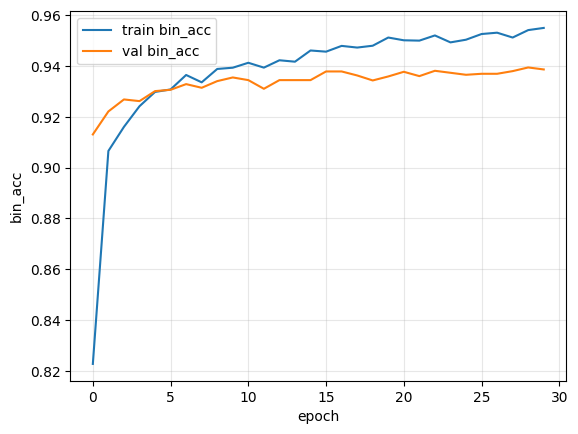

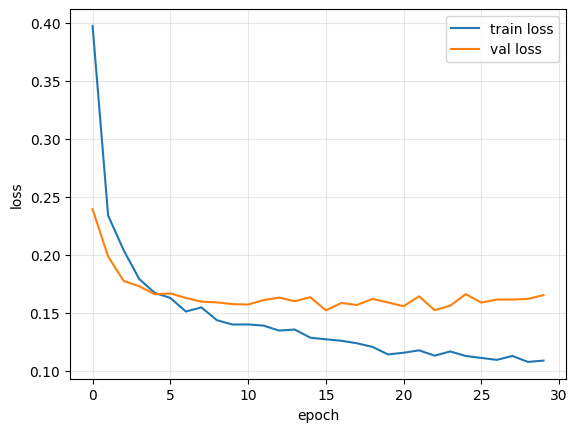

In [12]:
plt.figure()
plt.plot(history.history["bin_acc"], label="train bin_acc")
plt.plot(history.history["val_bin_acc"], label="val bin_acc")
plt.xlabel("epoch"); plt.ylabel("bin_acc"); plt.legend(); plt.grid(True, alpha=0.3)
plt.show()

plt.figure()
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="val loss")
plt.xlabel("epoch"); plt.ylabel("loss"); plt.legend(); plt.grid(True, alpha=0.3)
plt.show()


## Cell 13 — Metrics: Accuracy, Precision, FPR, FNR (per-class + overall)

In [ ]:
from sklearn.metrics import precision_score

y_prob = model.predict(X_test_s)
y_pred = (y_prob >= 0.5).astype(int)

#Overall (micro) precision
micro_prec = precision_score(y_test.reshape(-1), y_pred.reshape(-1), zero_division=0)
print("Micro Precision:", round(micro_prec, 4))

#Per-class Precision/FPR/FNR
def per_class_metrics(y_true, y_hat):
    metrics = []
    for j in range(y_true.shape[1]):
        yt = y_true[:, j]
        yp = y_hat[:, j]
        TP = np.sum((yt==1) & (yp==1))
        FP = np.sum((yt==0) & (yp==1))
        FN = np.sum((yt==1) & (yp==0))
        TN = np.sum((yt==0) & (yp==0))
        precision = TP / (TP + FP + 1e-9)
        fpr = FP / (FP + TN + 1e-9)
        fnr = FN / (FN + TP + 1e-9)
        acc = (TP + TN) / (TP + TN + FP + FN + 1e-9)
        metrics.append((j+1, acc, precision, fpr, fnr, int(np.sum(yt))))
    return pd.DataFrame(metrics, columns=["class","accuracy","precision","FPR","FNR","support"])

m = per_class_metrics(y_test, y_pred)
display(m.sort_values("support", ascending=False).head(15))


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Micro Precision: 0.8198


,class,accuracy,precision,FPR,FNR,support
23,24,0.909722,0.929752,0.314815,0.038462,234
8,9,0.864583,0.824324,0.169935,0.096296,135
29,30,0.833333,0.831461,0.082873,0.308411,107
4,5,0.798611,0.720430,0.137566,0.323232,99
13,14,0.840278,0.671429,0.105505,0.328571,70
7,8,0.850694,0.760000,0.054795,0.449275,69
6,7,0.888889,0.840909,0.030973,0.403226,62
17,18,0.822917,0.540000,0.098712,0.509091,55
0,1,0.906250,0.782609,0.042553,0.320755,53
27,28,0.940972,0.918919,0.012500,0.291667,48


## Cell 14 — So sánh với baseline SAEEC-like (đúng kiểu paper comparison)

In [ ]:
#Baseline dự đoán anomaly labels bằng rule đơn giản từ flags_saeeс:
#Nếu một ngày có bất kỳ slot bị flag -> baseline coi đó là anomaly-type 24 (max exceeds) + 1 label chung.
#(Paper baseline SAEEC không phải ANN; phần này chỉ để bạn có so sánh như paper)
baseline = np.zeros_like(y_test)
#map: class 24 index=23
baseline[:, 23] = (np.mean(flags_saeeс[ (np.arange(len(X_raw)))[-len(y_test):] ], axis=1) > 0).astype(int)

#metrics
m_base = per_class_metrics(y_test, baseline)
m_ann  = m

print("Baseline micro precision:", round(precision_score(y_test.reshape(-1), baseline.reshape(-1), zero_division=0), 4))
print("ANN micro precision:", round(precision_score(y_test.reshape(-1), y_pred.reshape(-1), zero_division=0), 4))

display(pd.DataFrame({
    "model": ["Baseline(SAEEC-like)", "ANN"],
    "micro_precision": [
        precision_score(y_test.reshape(-1), baseline.reshape(-1), zero_division=0),
        precision_score(y_test.reshape(-1), y_pred.reshape(-1), zero_division=0),
    ]
}))


Baseline micro precision: 0.7419
ANN micro precision: 0.8198


,model,micro_precision
0,Baseline(SAEEC-like),0.741935
1,ANN,0.819812


## Cell 15 — Xem dự đoán top classes cho 1 ngày test

In [15]:
test_idx = 0
prob = model.predict(X_test_s[test_idx:test_idx+1])[0]
top = np.argsort(-prob)[:10]
for j in top:
    print(f"Class {j+1:02d} prob={prob[j]:.3f} | {CLASS_NAMES[j]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Class 24 prob=0.998 | 24 Maximum exceeds expected
Class 05 prob=0.966 | 5 No unusual morning consumption outside typical work period
Class 08 prob=0.831 | 8 No abnormal nighttime consumption outside working period (charge from previous day possible)
Class 30 prob=0.752 | 30 Highest surpasses expected (heightened work activity)
Class 18 prob=0.590 | 18 Max exceeds expected; extra consumption extends into peak hours
Class 04 prob=0.116 | 4 No extraordinary consumption outside business hours
Class 14 prob=0.025 | 14 Limited abnormal occurrences within a day, no significant change in daily energy
Class 28 prob=0.007 | 28 Energy above expected (increased work activity)
Class 09 prob=0.003 | 9 Anomalous consumption during nighttime (continuous charging)
Class 01 prob=0.002 | 1 Standard pattern within expected range
